In [67]:
import os 
import re
import numpy as np
import pandas as pd
import helpers as h
import matplotlib.pyplot as plt

In [68]:
%mkdir ./img

mkdir: cannot create directory ‘./img’: File exists


In [69]:
EXPERIMENT_FOLDER = './aws_experiments/'

In [70]:
EXPERIMENT_NAMES = os.listdir(EXPERIMENT_FOLDER)

In [71]:
FF_EXPERIMENT_NAMES = [name for name in EXPERIMENT_NAMES if name.startswith('ff_')]
CONV_EXPERIMENT_NAMES = [name for name in EXPERIMENT_NAMES if name.startswith('conv_')]

In [72]:
def load_history(experiment_name):
    file_name = f'{EXPERIMENT_FOLDER}/{experiment_name}/history.pkl'
    return h.load_pickle(file_name)

In [73]:
FF_EXPERIMENT_HISTORIES = {name: load_history(name) for name in FF_EXPERIMENT_NAMES}
CONV_EXPERIMENT_HISTORIES = {name: load_history(name) for name in CONV_EXPERIMENT_NAMES}

In [74]:
uses_dropout = lambda name: 'dropout0.5' in name

In [75]:
def dropout_proportions_in_top_k(df):
    Ks = [10,20,30,40,50]
    dropout_proportions = [
        df.tail(1)\
          .stack()\
          .sort_values(ascending=False)\
          .head(K)\
          .loc[df.shape[0]-1]\
          .index\
          .to_series()\
          .apply(uses_dropout)\
          .mean()
        for K in Ks
    ]
    s = pd.Series(dropout_proportions)
    s.index = Ks
    return s

In [76]:
layer_sizes = lambda cond: [int(x) for x in 
                            re.findall('layers_(\d.*)_large', cond)[0]
                              .split('_')]

In [77]:
layer_conditions = h.load_pickle('hyperparameters/layer_conditions.pkl')

In [78]:
find_layer_condition = lambda layers: [cond for cond, sizes in layer_conditions.items() if layers in sizes][0]

### Feedforward

#### Training accuracy

In [79]:
train_acc_df = pd.DataFrame({name: history['accuracy'] for name, history in FF_EXPERIMENT_HISTORIES.items()})

In [80]:
train_acc_df.plot(legend=False, title='Training accuracy', alpha=0.33, color='darkred')
plt.savefig('./img/train_acc_vs_epoch.png')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f411baf55f8>,
      dtype=object)

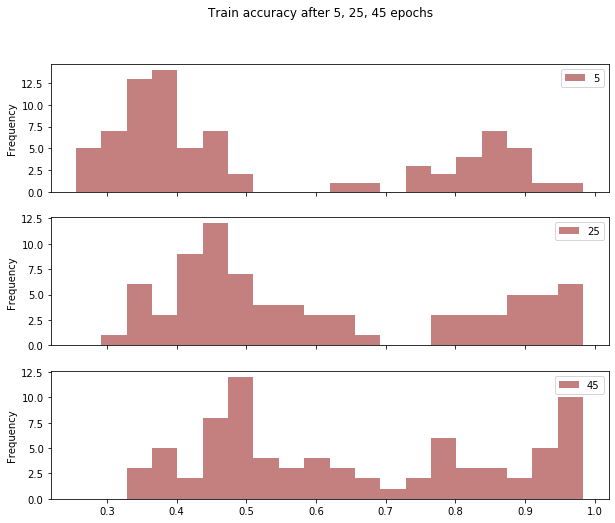

In [81]:
train_acc_df.loc[[5, 25, 45]]\
    .stack()\
    .unstack(level=0)\
    .plot(kind='hist', 
          subplots=True, legend='right',
          figsize=(10,8), bins=20, alpha=0.5, color='darkred',
          title='Train accuracy after 5, 25, 45 epochs')

#### Overall observations

- Two distinct groups of traces
- Bottom trace seems to "fan out" as training progresses
- Top traces seem to plateau much quicker
- Hypothesis: Top lines use dropout

Let's check the different train accuracies at the last epoch to investigate the hypothesis:

In [82]:
top_train_accuracies = train_acc_df\
                        .tail(1)\
                        .stack()\
                        .sort_values(ascending=False)\
                        .head(25)

In [83]:
top_train_accuracies_title = 'Top 50 train accuracies'
top_train_accuracies.plot(kind='hist', 
                        color='darkred', 
                        alpha=0.5, 
                        bins=15,
                        xlim=(0, 1),
                        title=top_train_accuracies_title)

In [84]:
dropout_proportions_in_top_k(train_acc_df).plot(kind='line', 
                                                title='Proportion of top K conditions that use Dropout', 
                                                color='darkred')

Interestingly, only about the experimental conditions that achieve top 25 training accuracies use dropout.

In [85]:
print(top_train_accuracies)

49  ff_stacked_padded__dropout0_layers_512_256_64_large               0.983710
    ff_stacked_padded__dropout0.5_layers_512_128_large                0.982419
    ff_stacked_padded__dropout0.5_layers_512_256_large                0.979622
    ff_stacked_padded__dropout0.5_layers_512_64_large                 0.978485
    ff_stacked_padded__dropout0_layers_512_256_128_large              0.976456
    ff_stacked_padded__dropout0_layers_512_64_128_64_128_large        0.973936
    ff_stacked_padded__dropout0.5_layers_512_256_64_large             0.961395
    ff_stacked_padded__dropout0.5_layers_512_256_128_large            0.960043
    ff_stacked_padded__dropout0.5_layers_512_128_64_large             0.953957
    ff_stacked_padded__dropout0.5_layers_512_64_128_large             0.951283
    ff_stacked_padded__dropout0_layers_512_256_128_64_large           0.945228
    ff_stacked_padded__dropout0.5_layers_512_256_128_64_large         0.935977
    ff_stacked_padded__dropout0.5_layers_512_64_256_

Let's see how this situation compares to validation accuracy on which we actually tune: 

#### Validation accuracy

In [86]:
val_acc_df = pd.DataFrame({name: history['val_accuracy'] for name, history in FF_EXPERIMENT_HISTORIES.items()})

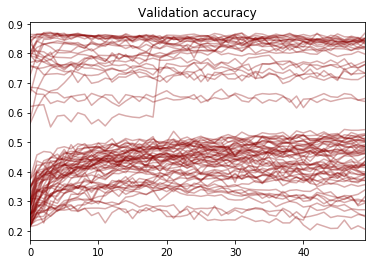

In [87]:
val_acc_df.plot(legend=False, 
                title='Validation accuracy', 
                alpha=0.33, color='darkred')
plt.savefig('./img/val_acc_vs_epoch.png')

In [88]:
val_acc_df.loc[[5, 25, 45]]\
    .stack()\
    .unstack(level=0)\
    .plot(kind='hist', 
          subplots=True, legend='right',
          figsize=(10,8), bins=20, alpha=0.5, color='darkred',
          title='Validation accuracy after 5, 25, 45 epochs')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f411bc3f7b8>,
      dtype=object)

#### Overall observations

- Two distinct groups of traces
- Overall there is more noise than in 
- Everything seems to plateau by ~10-20 epochs, subsequent epochs don't add much
- Hypothesis: Top lines use dropout

Let's check the different validation accuracies at the last epoch to investigate the hypothesis:

In [89]:
top_val_accuracies = val_acc_df\
                        .tail(1)\
                        .stack()\
                        .head(50)\
                        .loc[49]\
                        .sort_values(ascending=False)

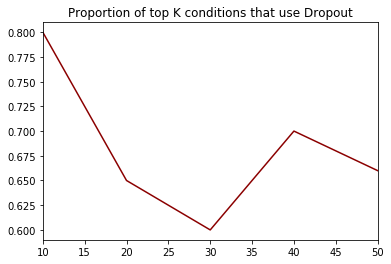

In [90]:
dropout_proportions_in_top_k(val_acc_df).plot(kind='line', 
                                              title='Proportion of top K conditions that use Dropout', 
                                              color='darkred')

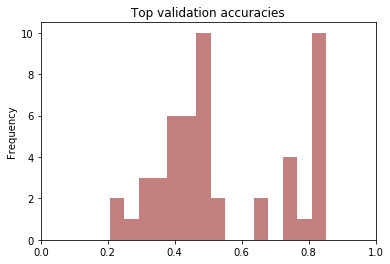

In [91]:
top_val_accuracies_title = 'Top validation accuracies'
top_val_accuracies.plot(kind='hist', 
                        color='darkred', 
                        alpha=0.5, 
                        bins=15,
                        xlim=(0, 1), 
                        title=top_val_accuracies_title)

In [92]:
top_layer_conditions = top_val_accuracies\
                        .index\
                        .to_series()\
                        .apply(lambda s: find_layer_condition(layer_sizes(s)))

In [93]:
top_val_df = pd.DataFrame({'validation_accuracy': top_val_accuracies, 'layer_condition': top_layer_conditions})
top_val_df.index.name = 'experiment'

In [94]:
top_val_df[(top_val_df.layer_condition == 'funnel')&(top_val_df.validation_accuracy>0.7)]

validation_accuracy  \
experiment                                                                
ff_stacked_padded__dropout0.5_layers_512_128_64...             0.851671   
ff_stacked_padded__dropout0.5_layers_512_128_large             0.850975   
ff_stacked_padded__dropout0.5_layers_512_256_large             0.843315   
ff_stacked_padded__dropout0.5_layers_512_256_12...             0.841922   
ff_stacked_padded__dropout0_layers_512_256_64_l...             0.840529   
ff_stacked_padded__dropout0_layers_512_256_128_...             0.819638   
ff_stacked_padded__dropout0_layers_512_256_128_...             0.814763   
ff_stacked_padded__dropout0_layers_512_128_64_l...             0.762535   
ff_stacked_padded__dropout0_layers_512_64_large                0.724930   

                                                   layer_condition  
experiment                                                          
ff_stacked_padded__dropout0.5_layers_512_128_64...          funnel  
ff_stacked_padded__dropout0.5_layers_512_128_large          funnel  
ff_stacked_padded__dropout0.5_layers_512_256_large          funnel  
ff_stacked_padded__dropout0.5_layers_512_256_12...          funnel  
ff_stacked_padded__dropout0_layers_512_256_64_l...          funnel  
ff_stacked_padded__dropout0_layers_512_256_128_...          funnel  
ff_stacked_padded__dropout0_layers_512_256_128_...          funnel  
ff_stacked_padded__dropout0_layers_512_128_64_l...          funnel  
ff_stacked_padded__dropout0_layers_512_64_large             funnel

In [95]:
top_val_df[(top_val_df.layer_condition == 'bottleneck')&(top_val_df.validation_accuracy>0.7)]

validation_accuracy  \
experiment                                                                
ff_stacked_padded__dropout0.5_layers_512_64_128...             0.849582   
ff_stacked_padded__dropout0.5_layers_512_64_256...             0.824513   
ff_stacked_padded__dropout0_layers_512_64_128_l...             0.772981   
ff_stacked_padded__dropout0_layers_512_64_256_l...             0.733287   

                                                   layer_condition  
experiment                                                          
ff_stacked_padded__dropout0.5_layers_512_64_128...      bottleneck  
ff_stacked_padded__dropout0.5_layers_512_64_256...      bottleneck  
ff_stacked_padded__dropout0_layers_512_64_128_l...      bottleneck  
ff_stacked_padded__dropout0_layers_512_64_256_l...      bottleneck

In [111]:
_ = top_val_accuracies.head(10).reset_index()
_.columns

experiment         0
0  ff_stacked_padded__dropout0.5_layers_512_128_6...  0.851671
1  ff_stacked_padded__dropout0.5_layers_512_128_l...  0.850975
2  ff_stacked_padded__dropout0.5_layers_512_64_12...  0.849582
3  ff_stacked_padded__dropout0.5_layers_512_256_l...  0.843315
4  ff_stacked_padded__dropout0.5_layers_512_256_1...  0.841922
5  ff_stacked_padded__dropout0_layers_512_256_64_...  0.840529
6  ff_stacked_padded__dropout0.5_layers_512_64_12...  0.832173
7  ff_stacked_padded__dropout0.5_layers_512_64_25...  0.824513
8  ff_stacked_padded__dropout0_layers_512_256_128...  0.819638
9  ff_stacked_padded__dropout0_layers_512_256_128...  0.814763

#### Overall obsercvations

- Top 8 results all use dropout
- `stacked_padded` features absolutely dominate
- `funnel` seems like the best feature type, only 4 `bottleneck` configs achieve over 0.7 validation accuracy

### Treatment effect of dropout

In [96]:
conditions = val_acc_df.stack().loc[49].index.to_series()

In [97]:
conditions_wo_dropout = conditions.apply(lambda s: re.sub('_dropout0[\.5]*_', '', s))

In [98]:
condition_uses_dropout = conditions.apply(uses_dropout)

In [99]:
dropout_df = pd.DataFrame({
    'condition_wo_dropout': conditions_wo_dropout,
    'uses_dropout': condition_uses_dropout,
    'validation_accuracy': val_acc_df.stack().loc[49]
})

In [100]:
effect_of_dropout = dropout_df\
                    .reset_index()\
                    .drop('index', 1)\
                    .set_index(['condition_wo_dropout', 
                                'uses_dropout'])\
                    .unstack()

In [101]:
dropout_treatment_effect = effect_of_dropout.diff(axis=1)['validation_accuracy'][True]

In [102]:
DROPOUT_TREATMENT_EFFECT_TITLE = '"Treatment effect" of using dropout (solid line = median, dashed line = mean)'
ax = dropout_treatment_effect.plot(kind='hist', bins=20,
                                   title=DROPOUT_TREATMENT_EFFECT_TITLE,
                                   color='darkred',
                                   alpha=0.5)
ax.axvline(x=dropout_treatment_effect.mean(), 
           color='black', 
           linestyle='dashed', 
           linewidth=3)

ax.axvline(x=dropout_treatment_effect.median(), 
          color='black', 
          linestyle='solid', 
          linewidth=3)
plt.savefig('./img/dropout_validation_treatment_effect_feedforward.png')

In [103]:
dropout_treatment_effect.mean()

0.10852796336015065

In [108]:
val_acc_df.loc[49].sort_values(ascending=False).head()

ff_stacked_padded__dropout0.5_layers_512_64_large        0.868384
ff_stacked_padded__dropout0.5_layers_512_128_64_large    0.851671
ff_stacked_padded__dropout0.5_layers_512_128_large       0.850975
ff_stacked_padded__dropout0.5_layers_512_256_64_large    0.850279
ff_stacked_padded__dropout0.5_layers_512_64_128_large    0.849582
Name: 49, dtype: float64

## Best Feedforward configs

ff_stacked_padded__dropout0.5_layers_512_64_large

### Convolutional

In [57]:
train_acc_df = pd.DataFrame({name: history['accuracy'] for name, history in CONV_EXPERIMENT_HISTORIES.items()})

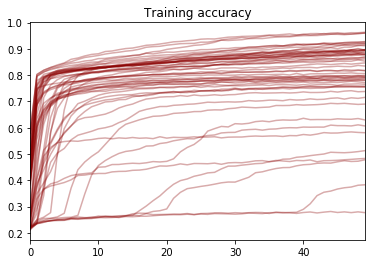

In [58]:
train_acc_df.plot(legend=False, title='Training accuracy', alpha=0.33, color='darkred')
plt.savefig('./img/conv_train_acc_vs_epoch.png')

In [59]:
val_acc_df = pd.DataFrame({name: history['val_accuracy'] for name, history in CONV_EXPERIMENT_HISTORIES.items()})

In [60]:
val_acc_df.plot(legend=False, 
                title='Validation accuracy (Conv)', 
                alpha=0.33, color='darkred')
plt.savefig('./img/conv_val_acc_vs_epoch.png')

In [61]:
conditions = val_acc_df.stack().loc[49].index.to_series()
conditions_wo_dropout = conditions.apply(lambda s: re.sub('convdropout0[\.5]*_', '', s))
condition_uses_dropout = conditions.apply(uses_dropout)

In [62]:
dropout_df = pd.DataFrame({
    'condition_wo_dropout': conditions_wo_dropout,
    'uses_dropout': condition_uses_dropout,
    'validation_accuracy': val_acc_df.stack().loc[49]
})

In [63]:
effect_of_dropout = dropout_df\
                    .reset_index()\
                    .drop('index', 1)\
                    .set_index(['condition_wo_dropout', 
                                'uses_dropout'])\
                    .unstack()

In [64]:
dropout_treatment_effect = effect_of_dropout.diff(axis=1)['validation_accuracy'][True]

In [65]:
DROPOUT_TREATMENT_EFFECT_TITLE = '"Treatment effect" of using conv dropout (solid line = median, dashed line = mean)'
ax = dropout_treatment_effect.plot(kind='hist', bins=20,
                                   title=DROPOUT_TREATMENT_EFFECT_TITLE,
                                   color='darkred',
                                   alpha=0.5)
ax.axvline(x=dropout_treatment_effect.mean(), 
           color='black', 
           linestyle='dashed', 
           linewidth=3)

ax.axvline(x=dropout_treatment_effect.median(), 
          color='black', 
          linestyle='solid', 
          linewidth=3)
plt.savefig('./img/dropout_validation_treatment_effect_val_conv.png')

In [66]:
val_acc_df.stack().loc[49].sort_values(ascending=False)

conv_stacked_padded__convdropout0.5_nconv1_filters50_kernelsize3_fclayers_512_128_large                       0.862117
conv_stacked_padded__convdropout0_nconv3_filters50_150_250_kernelsize2_fclayers_512_128_64_large              0.862117
conv_stacked_padded__convdropout0.5_nconv3_filters50_150_250_kernelsize2_fclayers_512_128_large               0.857242
conv_stacked_padded__convdropout0_nconv5_filters50_150_250_350_450_kernelsize4_fclayers_512_64_128_large      0.856546
conv_stacked_padded__convdropout0.5_nconv1_filters50_kernelsize2_fclayers_512_128_large                       0.854457
conv_stacked_padded__convdropout0.5_nconv1_filters50_kernelsize4_fclayers_512_128_large                       0.853760
conv_stacked_padded__convdropout0_nconv5_filters50_150_250_350_450_kernelsize3_fclayers_512_128_64_large      0.851671
conv_stacked_padded__convdropout0_nconv5_filters50_150_250_350_450_kernelsize2_fclayers_512_64_128_large      0.850975
conv_stacked_padded__convdropout0_nconv3_filters

# Best convolutional configs

conv_stacked_padded__convdropout0.5_nconv1_filters50_kernelsize3_fclayers_512_128_large